In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from datasets import load_dataset

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x) 

In [86]:
# data subset is hosted on huggingface

dataset = load_dataset(
    "dgrant6/down_sampled_file_traffic_dataset2",
    data_files={
        "test": "test-00000-of-00001.parquet",
        "train": "train-00000-of-00001.parquet"
    }
)

dataset.shape

{'test': (200000, 10), 'train': (800000, 10)}

In [87]:
# converting the huggingface parquet files into Pandas DataFrames
df = dataset['train'].to_pandas()
df_test = dataset['test'].to_pandas()

In [88]:
print(df.head())
print("*" * 80)
print(df.dtypes)

   avgSpeed  junction            TIMESTAMP  vehicleCount  Year  Month  \
0        41      1041  2014-02-13 11:30:00             4  2014      2   
1         0       744  2014-02-13 11:30:00             0  2014      2   
2        35       652  2014-02-13 11:30:00             0  2014      2   
3        50       749  2014-02-13 11:30:00            11  2014      2   
4        50       759  2014-02-13 11:30:00            15  2014      2   

   Date_no  Hour       Day             unix  
0       13    11  Thursday 1392291000.00000  
1       13    11  Thursday 1392291000.00000  
2       13    11  Thursday 1392291000.00000  
3       13    11  Thursday 1392291000.00000  
4       13    11  Thursday 1392291000.00000  
********************************************************************************
avgSpeed          int64
junction          int64
TIMESTAMP        object
vehicleCount      int64
Year              int64
Month             int64
Date_no           int64
Hour              int64
Day         

In [89]:
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df_test['TIMESTAMP'] = pd.to_datetime(df_test['TIMESTAMP'])

# df = pd.get_dummies(df, columns=['Day'], drop_first=True)
label_encoder = LabelEncoder()
df['Day'] = label_encoder.fit_transform(df['Day'])
df_test['Day'] = label_encoder.fit_transform(df_test['Day'])

print(df.dtypes)
print("*" * 80)
print(df_test.dtypes)

avgSpeed                 int64
junction                 int64
TIMESTAMP       datetime64[ns]
vehicleCount             int64
Year                     int64
Month                    int64
Date_no                  int64
Hour                     int64
Day                      int64
unix                   float64
dtype: object
********************************************************************************
avgSpeed                 int64
junction                 int64
TIMESTAMP       datetime64[ns]
vehicleCount             int64
Year                     int64
Month                    int64
Date_no                  int64
Hour                     int64
Day                      int64
unix                   float64
dtype: object


In [90]:
desc = df.describe(include='all')
desc

,avgSpeed,junction,TIMESTAMP,vehicleCount,Year,Month,Date_no,Hour,Day,unix
count,800000.00000,800000.00000,800000,800000.00000,800000.00000,800000.00000,800000.00000,800000.00000,800000.00000,800000.00000
mean,43.64888,827.68204,2014-03-31 05:26:11.040750080,3.25050,2014.00000,3.49053,15.16852,11.25824,3.00483,1396243571.04075
min,0.00000,610.00000,2014-02-13 11:30:00,0.00000,2014.00000,2.00000,1.00000,0.00000,0.00000,1392291000.00000
25%,29.00000,716.00000,2014-03-07 16:20:00,0.00000,2014.00000,3.00000,8.00000,6.00000,1.00000,1394209200.00000
50%,43.00000,824.00000,2014-04-01 06:40:00,1.00000,2014.00000,4.00000,15.00000,11.00000,3.00000,1396334400.00000
75%,57.00000,938.00000,2014-04-23 03:35:00,4.00000,2014.00000,4.00000,22.00000,17.00000,5.00000,1398224100.00000
max,149.00000,1058.00000,2014-05-15 16:30:00,92.00000,2014.00000,5.00000,31.00000,23.00000,6.00000,1400171400.00000
std,22.10179,128.82472,NaN,6.04203,0.00000,0.96177,8.51710,6.70249,2.00199,2293769.99330


<Axes: >

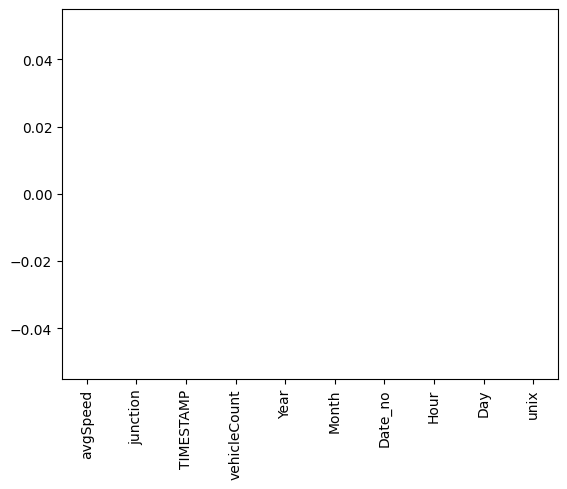

In [91]:
df.isna().sum().plot.bar()

In [92]:
junction_counts = df['junction'].value_counts()
print(junction_counts)

junction
620     1984
729     1971
687     1965
673     1956
634     1951
        ... 
1049    1571
1034    1570
1046    1566
1035    1556
1037    1552
Name: count, Length: 449, dtype: int64


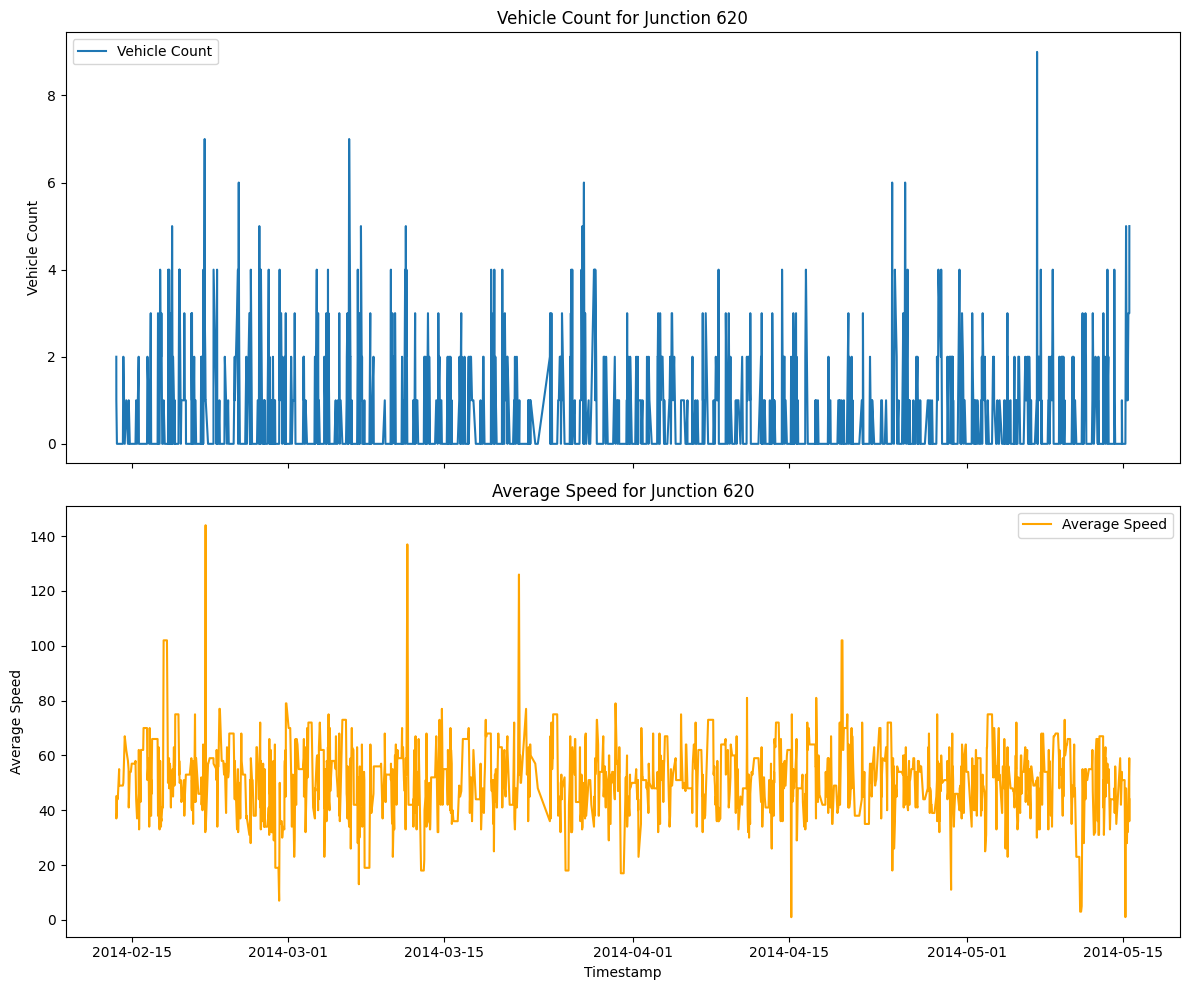

In [93]:
most_common_junction = df['junction'].value_counts().idxmax()

# Extract data for the most common junction
most_common_junction_data = df[df['junction'] == most_common_junction]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot Vehicle Count
ax1.plot(most_common_junction_data['TIMESTAMP'], most_common_junction_data['vehicleCount'], label='Vehicle Count')
ax1.set_ylabel('Vehicle Count')
ax1.set_title('Vehicle Count for Junction {}'.format(most_common_junction))
ax1.legend()

# Plot Average Speed
ax2.plot(most_common_junction_data['TIMESTAMP'], most_common_junction_data['avgSpeed'], label='Average Speed', color='orange')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Average Speed')
ax2.set_title('Average Speed for Junction {}'.format(most_common_junction))
ax2.legend()

plt.tight_layout()
plt.show()

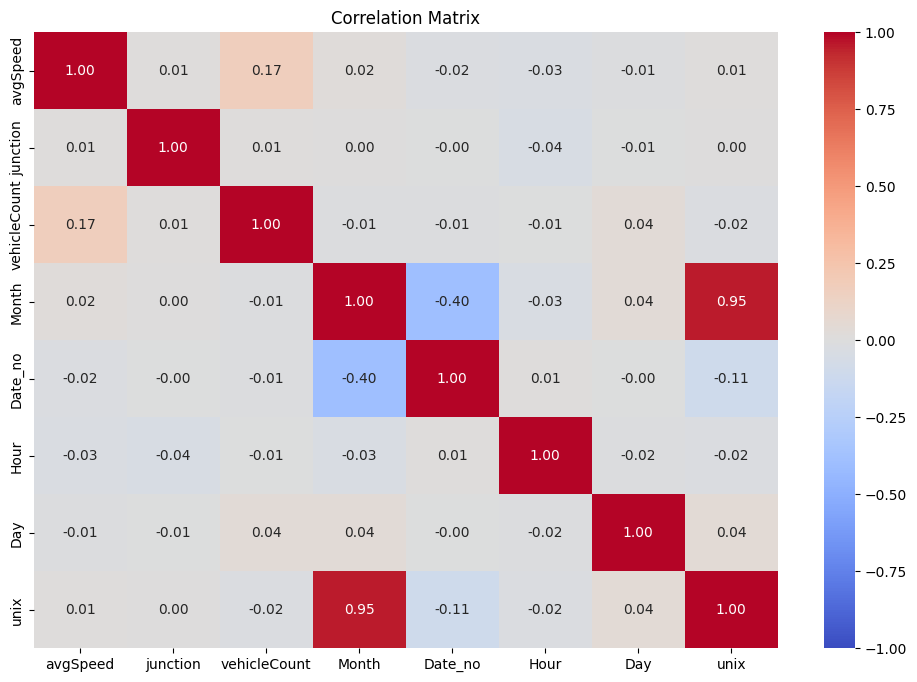

In [94]:
# Exclude non-numeric columns and 'Year'
numeric_columns = df.select_dtypes(include=['number']).columns
numeric_columns = numeric_columns.drop('Year')  # Exclude 'Year'
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Mean Squared Error on Test Data: 479.4696410135677


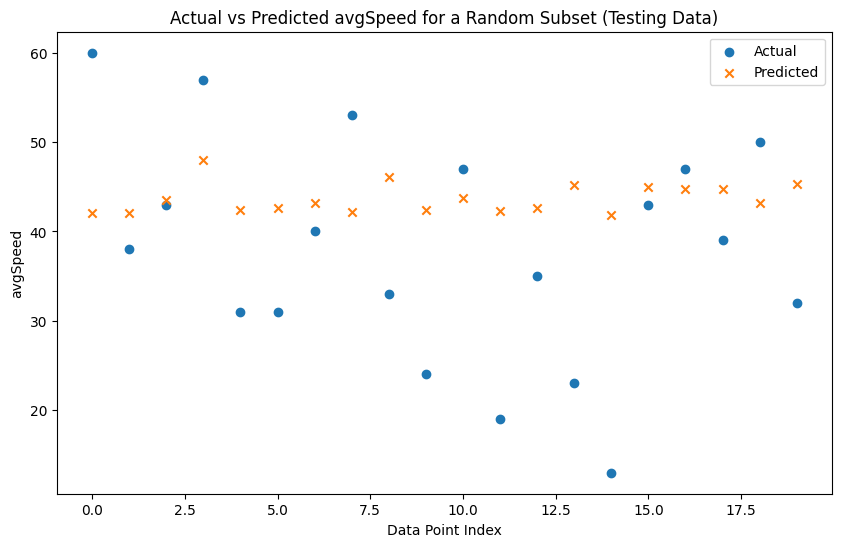

In [98]:
# Select relevant features and target variable
X_train = df[['vehicleCount', 'unix', 'Hour', 'Month', 'Day']]
y_train = df['avgSpeed']

# Select relevant features and target variable
X_test = df_test[['vehicleCount', 'unix', 'Hour', 'Month', 'Day']]
y_test = df_test['avgSpeed']

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
predictions = model.predict(X_test_scaled)

# Evaluate the model
mse_ = mse(y_test, predictions)
print(f'Mean Squared Error on Test Data: {mse_}')

# Choose a random subset of the test data (e.g., first 200 data points)
subset_indices = np.random.choice(len(X_test), size=20, replace=False)

# Extract actual and predicted values for the subset
subset_actual_values = y_test.iloc[subset_indices].values
subset_predicted_values = predictions[subset_indices]

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(subset_actual_values)), subset_actual_values, label='Actual', marker='o')
plt.scatter(range(len(subset_predicted_values)), subset_predicted_values, label='Predicted', marker='x')
plt.xlabel('Data Point Index')
plt.ylabel('avgSpeed')
plt.title('Actual vs Predicted avgSpeed for a Random Subset (Testing Data)')
plt.legend()
plt.show()

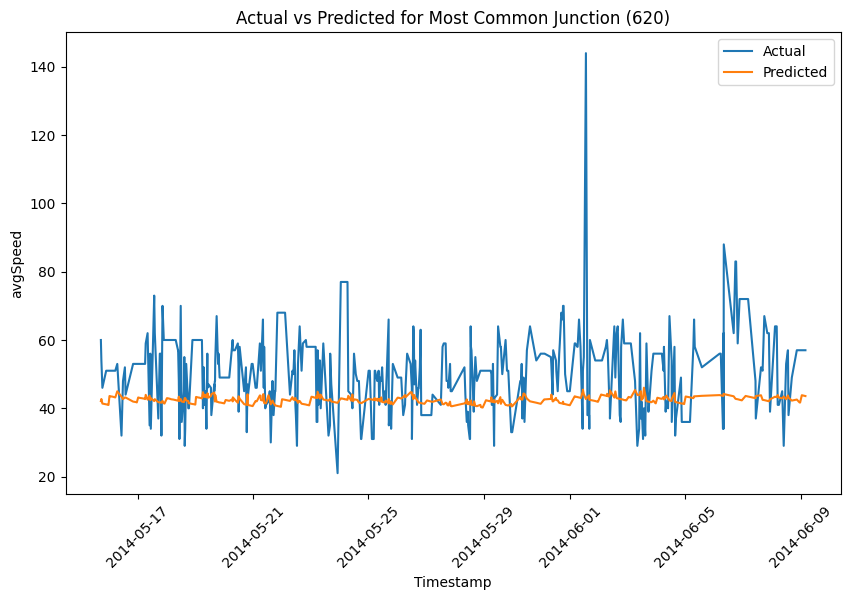

In [121]:
# Use the trained model to make predictions for the most common junction
most_common_junction_predictions = model.predict(scaler.transform(most_common_junction_data[['vehicleCount', 'unix', 'Hour', 'Month', 'Day']]))

# Plot actual vs predicted values for the most common junction
plt.figure(figsize=(10, 6))
plt.plot(most_common_junction_data['TIMESTAMP'], most_common_junction_data['avgSpeed'], label='Actual')
plt.plot(most_common_junction_data['TIMESTAMP'], most_common_junction_predictions, label='Predicted')

plt.xlabel('Timestamp')
plt.xticks(rotation=45)
plt.ylabel('avgSpeed')
plt.title(f'Actual vs Predicted for Most Common Junction ({most_common_junction})')
plt.legend()
plt.show()

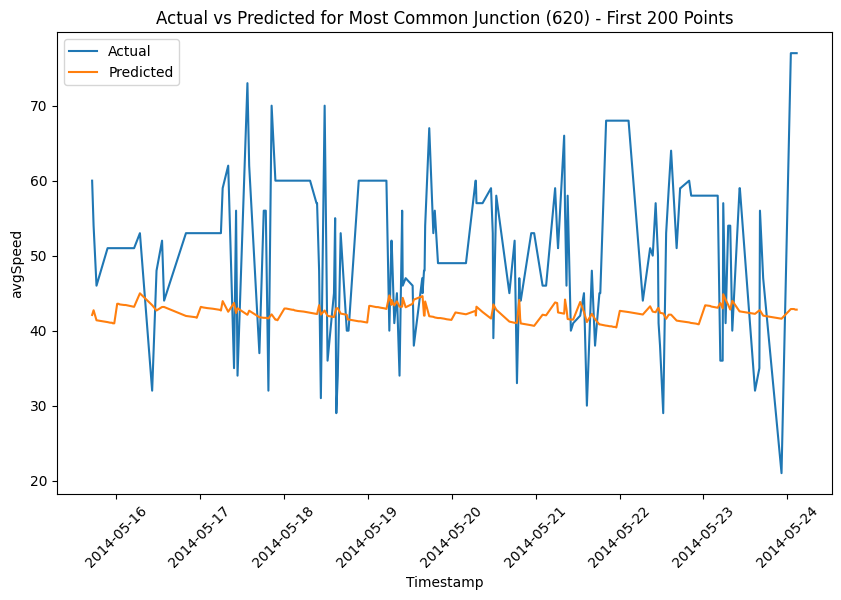

In [119]:
# Plot actual vs predicted values for the most common junction (first 200 points)
plt.figure(figsize=(10, 6))

plt.plot(most_common_junction_data['TIMESTAMP'].iloc[:200], most_common_junction_data['avgSpeed'].iloc[:200], label='Actual')
plt.plot(most_common_junction_data['TIMESTAMP'].iloc[:200], most_common_junction_predictions[:200], label='Predicted')

plt.xlabel('Timestamp')
plt.xticks(rotation=45)
plt.ylabel('avgSpeed')
plt.title(f'Actual vs Predicted for Most Common Junction ({most_common_junction}) - First 200 Points')
plt.legend()
plt.show()